# UMAP on the Airfoil Self-Noise Dataset

This notebook demonstrates an end-to-end example using UMAP for dimensionality reduction and visualization on the **Airfoil Self-Noise** dataset (NASA / UCI). The notebook downloads the dataset at runtime from the UCI repository, performs preprocessing, runs UMAP with a few parameter settings, visualizes embeddings, and optionally performs clustering on the embeddings.



In [ ]:
# 1) Imports (and install UMAP if needed)
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# try import umap, if missing instruct user to install (the notebook will attempt to pip install if allowed)
try:
    import umap
except Exception as e:
    print('UMAP not found. Attempting to install umap-learn...')
    try:
        !{sys.executable} -m pip install umap-learn --quiet
        import umap
        print('umap-learn installed.')
    except Exception as ie:
        print('Could not install umap-learn automatically. Please run: pip install umap-learn')

In [ ]:
# 2) Download dataset from UCI (runtime)
# Source: UCI Machine Learning Repository - Airfoil Self-Noise
# URL used to download the raw .dat file:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'

# Column names (from UCI dataset description)
col_names = ['Frequency','Angle_of_attack','Chord_length','Free_stream_velocity','Suction_side_displacement_thickness','Scaled_sound_pressure_level']

print('Attempting to download from:', url)
try:
    # the file uses whitespace-separated columns
    df = pd.read_csv(url, header=None, delim_whitespace=True, names=col_names)
    print('Downloaded dataset shape:', df.shape)
    display(df.head())
except Exception as e:
    print('Download failed in this environment. Error:', e)
    print('If offline, download the file from the UCI page and place it next to this notebook.')
    df = pd.DataFrame(columns=col_names)


Attempting to download from: https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat
Downloaded dataset shape: (1503, 6)


/tmp/ipython-input-2628344976.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(url, header=None, delim_whitespace=True, names=col_names)


,Frequency,Angle_of_attack,Chord_length,Free_stream_velocity,Suction_side_displacement_thickness,Scaled_sound_pressure_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


In [ ]:
# 3) Quick checks and preprocessing
print('Columns:', df.columns.tolist())
print('\nFirst few rows:')
try:
    display(df.head())
except Exception:
    print(df.head())

print('\nBasic stats:')
print(df.describe())

# No missing values expected per UCI, but check
print('\nMissing values per column:')
print(df.isna().sum())

# Separate features and target (target is the last column: Scaled sound pressure level)
if not df.empty:
    X = df.drop('Scaled_sound_pressure_level', axis=1).values
    y = df['Scaled_sound_pressure_level'].values
    print('\nX shape:', X.shape, 'y shape:', y.shape)
else:
    X = None
    y = None


Columns: ['Frequency', 'Angle_of_attack', 'Chord_length', 'Free_stream_velocity', 'Suction_side_displacement_thickness', 'Scaled_sound_pressure_level']

First few rows:


,Frequency,Angle_of_attack,Chord_length,Free_stream_velocity,Suction_side_displacement_thickness,Scaled_sound_pressure_level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461



Basic stats:
          Frequency  Angle_of_attack  Chord_length  Free_stream_velocity  \
count   1503.000000      1503.000000   1503.000000           1503.000000   
mean    2886.380572         6.782302      0.136548             50.860745   
std     3152.573137         5.918128      0.093541             15.572784   
min      200.000000         0.000000      0.025400             31.700000   
25%      800.000000         2.000000      0.050800             39.600000   
50%     1600.000000         5.400000      0.101600             39.600000   
75%     4000.000000         9.900000      0.228600             71.300000   
max    20000.000000        22.200000      0.304800             71.300000   

       Suction_side_displacement_thickness  Scaled_sound_pressure_level  
count                          1503.000000                  1503.000000  
mean                              0.011140                   124.835943  
std                               0.013150                     6.898657  
min  

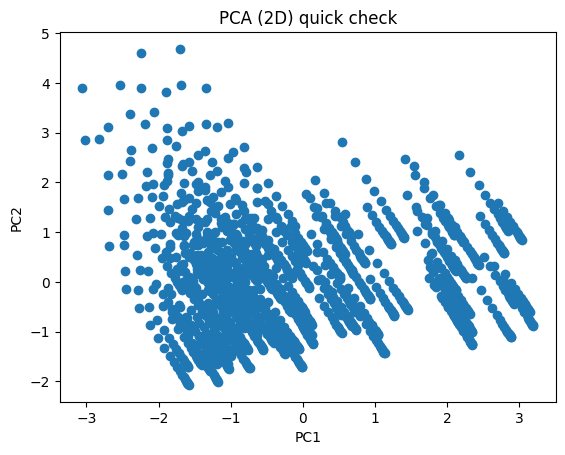

In [ ]:
# 4) Standardize features and optional PCA preprocessing
if X is not None:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Optional: PCA to inspect variance
    pca = PCA(n_components=2, random_state=0)
    X_pca = pca.fit_transform(X_scaled)
    plt.figure()
    plt.scatter(X_pca[:,0], X_pca[:,1])
    plt.title('PCA (2D) quick check')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.show()
else:
    print('No data to process. Did the download fail?')


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


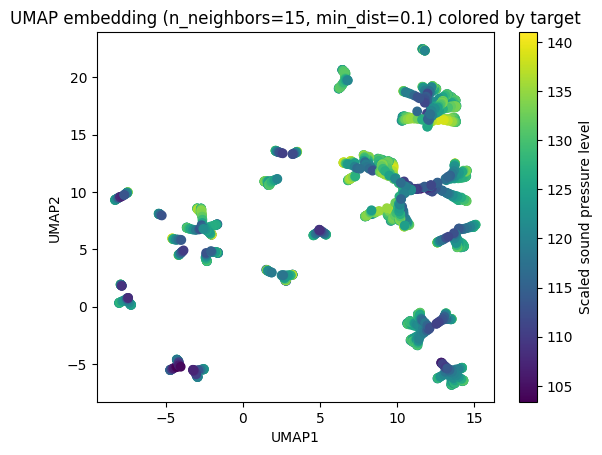

In [ ]:
# 5) UMAP: baseline embedding
# Typical parameters to try: n_neighbors (5-200), min_dist (0.0-0.99), metric (euclidean, manhattan, cosine)
if X is not None:
    reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42)
    X_umap = reducer.fit_transform(X_scaled)
    plt.figure()
    sc = plt.scatter(X_umap[:,0], X_umap[:,1], c=y, cmap='viridis')
    plt.colorbar(sc, label='Scaled sound pressure level')
    plt.title('UMAP embedding (n_neighbors=15, min_dist=0.1) colored by target')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.show()
else:
    print('No data available to run UMAP.')


Running UMAP with n_neighbors=5, min_dist=0.0


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


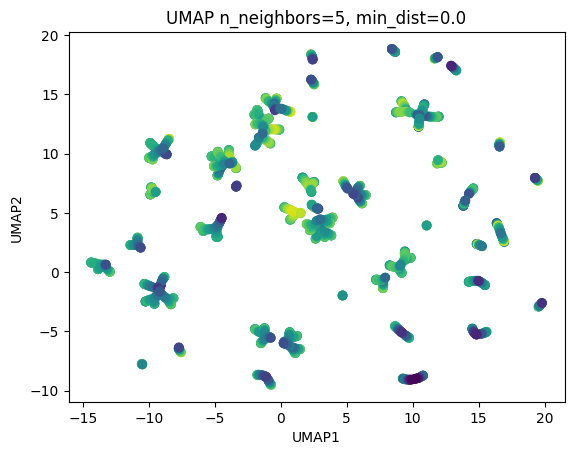

Running UMAP with n_neighbors=5, min_dist=0.1


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


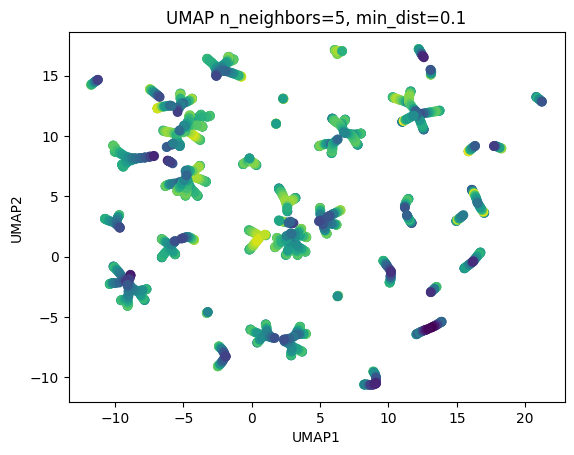

Running UMAP with n_neighbors=5, min_dist=0.5


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


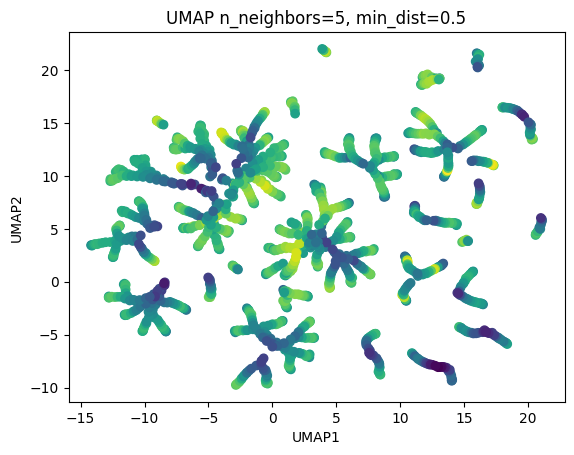

Running UMAP with n_neighbors=15, min_dist=0.0


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


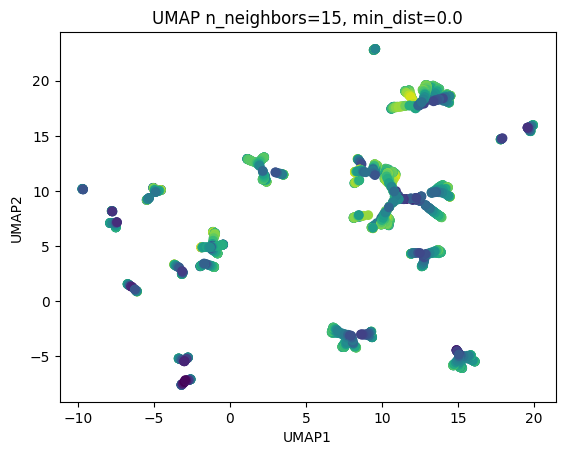

Running UMAP with n_neighbors=15, min_dist=0.1


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


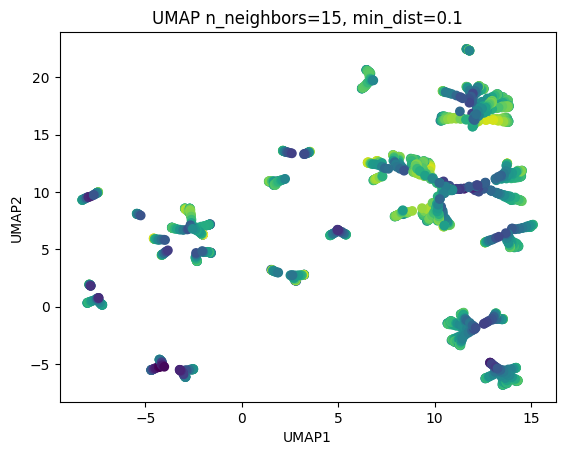

Running UMAP with n_neighbors=15, min_dist=0.5


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


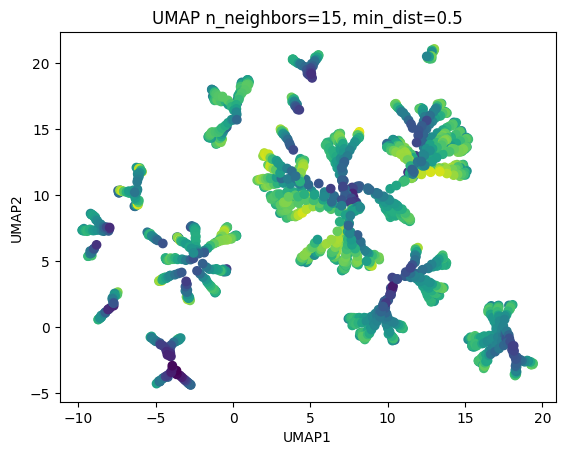

Running UMAP with n_neighbors=50, min_dist=0.0


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


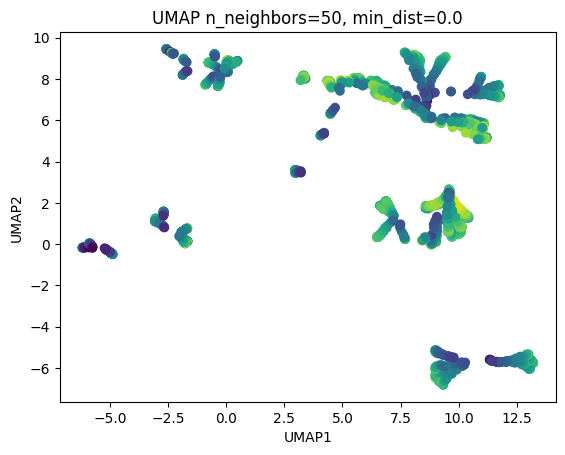

Running UMAP with n_neighbors=50, min_dist=0.1


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


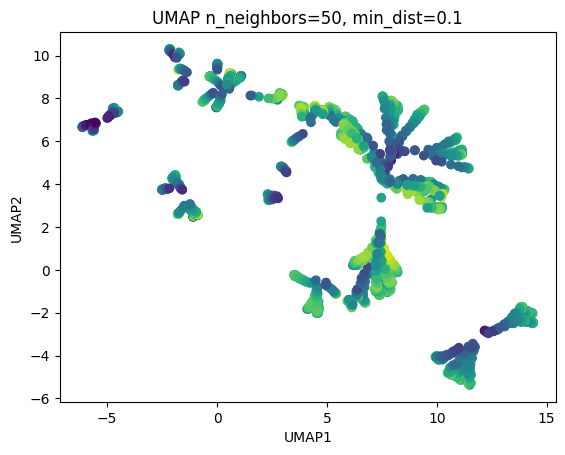

Running UMAP with n_neighbors=50, min_dist=0.5


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


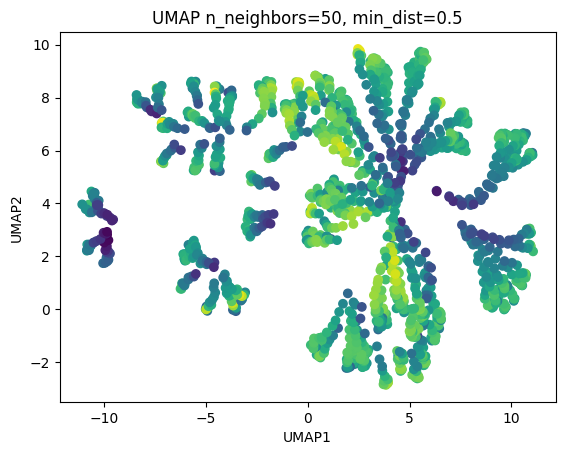

Parameter sweep complete. Embeddings stored in `results` dict.


In [ ]:
# 6) UMAP parameter sweep (several n_neighbors and min_dist values)
if X is not None:
    n_neighbors_list = [5, 15, 50]
    min_dist_list = [0.0, 0.1, 0.5]
    results = {}
    for nn in n_neighbors_list:
        for md in min_dist_list:
            print(f'Running UMAP with n_neighbors={nn}, min_dist={md}')
            reducer = umap.UMAP(n_components=2, n_neighbors=nn, min_dist=md, metric='euclidean', random_state=42)
            emb = reducer.fit_transform(X_scaled)
            results[f'n{nn}_d{md}'] = emb
            plt.figure()
            plt.scatter(emb[:,0], emb[:,1], c=y)
            plt.title(f'UMAP n_neighbors={nn}, min_dist={md}')
            plt.xlabel('UMAP1')
            plt.ylabel('UMAP2')
            plt.show()
    print('Parameter sweep complete. Embeddings stored in `results` dict.')
else:
    print('No data available for parameter sweep.')


In [ ]:
# 7) Optional: clustering on UMAP embeddings + silhouette score
if X is not None:
    for k in [2,3,4]:
        kmeans = KMeans(n_clusters=k, random_state=0)
        lbls = kmeans.fit_predict(X_umap)
        sil = silhouette_score(X_umap, lbls)
        print(f'KMeans k={k} on UMAP coords -> silhouette: {sil:.4f}')

    # Also compare clustering on original standardized features
    for k in [2,3,4]:
        kmeans = KMeans(n_clusters=k, random_state=0)
        lbls = kmeans.fit_predict(X_scaled)
        sil = silhouette_score(X_scaled, lbls)
        print(f'KMeans k={k} on standardized features -> silhouette: {sil:.4f}')
else:
    print('No data for clustering.')


KMeans k=2 on UMAP coords -> silhouette: 0.4711
KMeans k=3 on UMAP coords -> silhouette: 0.5458
KMeans k=4 on UMAP coords -> silhouette: 0.4051
KMeans k=2 on standardized features -> silhouette: 0.3068
KMeans k=3 on standardized features -> silhouette: 0.2876
KMeans k=4 on standardized features -> silhouette: 0.2671


In [ ]:
# 8) Save an embedding CSV for later use
out_dir = 'airfoil_umap_outputs'
os.makedirs(out_dir, exist_ok=True)
if X is not None:
    emb_df = pd.DataFrame(X_umap, columns=['UMAP1','UMAP2'])
    emb_df['Scaled_sound_pressure_level'] = y
    csv_path = os.path.join(out_dir, 'airfoil_umap_baseline.csv')
    emb_df.to_csv(csv_path, index=False)
    print('Saved baseline UMAP embedding to', csv_path)
else:
    print('No embedding to save.')


Saved baseline UMAP embedding to airfoil_umap_outputs/airfoil_umap_baseline.csv
